In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt

#from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform = mnist_transform)

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [5]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        #dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - rho*torch.log(self.data_rho)-(1-rho)*torch.log(1-self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [6]:
models = {'32': Net(32)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                #test_loss[k] += m.loss(output[k], data).item()
                test_loss[k] += m.loss(output[k], data, reduction = 'sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 32: 1.015005
Train Epoch: 1 [10000/50000 (20%)]	Losses 32: 0.872399
Train Epoch: 1 [20000/50000 (40%)]	Losses 32: 0.699552
Train Epoch: 1 [30000/50000 (60%)]	Losses 32: 0.518089
Train Epoch: 1 [40000/50000 (80%)]	Losses 32: 0.408900
Train Epoch: 1 [50000/50000 (100%)]	Losses 32: 0.367104
Test set:
32: loss: 0.3757	rho_loss: 0.0063

Train Epoch: 2 [0/50000 (0%)]	Losses 32: 0.391003
Train Epoch: 2 [10000/50000 (20%)]	Losses 32: 0.353430
Train Epoch: 2 [20000/50000 (40%)]	Losses 32: 0.315872
Train Epoch: 2 [30000/50000 (60%)]	Losses 32: 0.296933
Train Epoch: 2 [40000/50000 (80%)]	Losses 32: 0.281607
Train Epoch: 2 [50000/50000 (100%)]	Losses 32: 0.251355
Test set:
32: loss: 0.2664	rho_loss: 0.0057

Train Epoch: 3 [0/50000 (0%)]	Losses 32: 0.265478
Train Epoch: 3 [10000/50000 (20%)]	Losses 32: 0.250457
Train Epoch: 3 [20000/50000 (40%)]	Losses 32: 0.242451
Train Epoch: 3 [30000/50000 (60%)]	Losses 32: 0.247265
Train Epoch: 3 [40000/50000 (80%)]	Losses 3

In [11]:
data, _ = next(iter(test_loader))
output = models['32'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['32'].decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['32'].E(data.view(-1, 28*28))
    print('кол-во активных нейронов на каждом векторе сета:')
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['32'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

кол-во активных нейронов на каждом векторе сета:
tensor([3, 2, 1, 3, 3, 2, 0, 2, 1, 2, 3, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1,
        0, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 3, 1, 2, 1,
        2, 3])


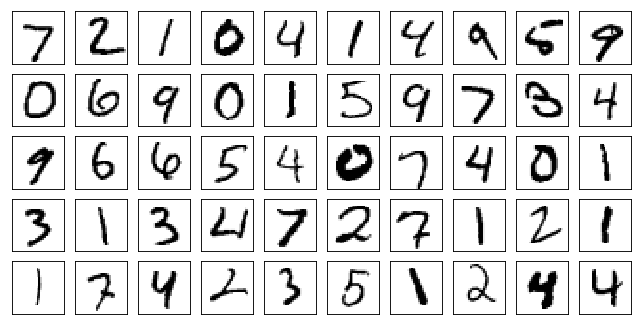

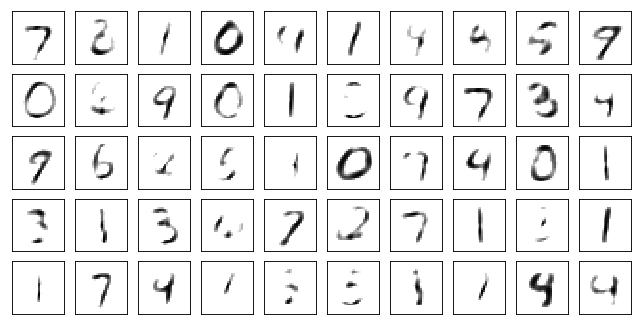

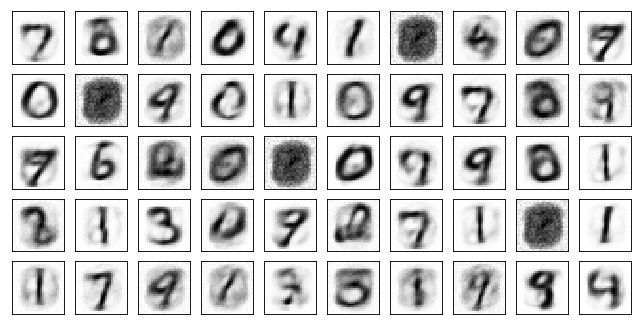

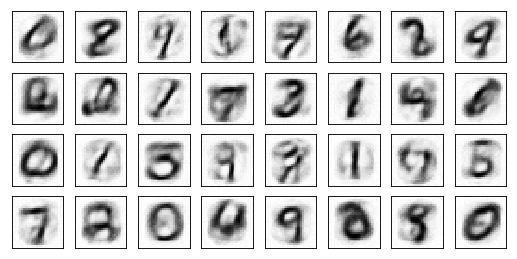

In [12]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

## Заменить sigmoid+KL на tanh+L1 и проверить работает ли такой подход

In [14]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [15]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._l1_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        #self.data_rho = h.mean(0)
        #self.l1 = torch.abs(self.E.fc1.weight)
        self.l1 = torch.abs(h)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        #dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - rho*torch.log(self.data_rho)-(1-rho)*torch.log(1-self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def l1_loss(self, lyambda, size_average=True):
        l1 = lyambda*self.l1
        if size_average:
            self._l1_loss = l1.mean()
        else:
            self._l1_loss = l1.sum()
        return self._l1_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [16]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            l1_loss = model.l1_loss(lyambda)
            loss = model.loss(output, data) + l1_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [17]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
l1_lambda = lambda p: 'l1_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + l1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    l1_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                #test_loss[k] += m.loss(output[k], data).item()
                test_loss[k] += m.loss(output[k], data, reduction = 'sum').item() # sum up batch loss
                l1_loss[k] += m.l1_loss(lyambda, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        l1_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], l1_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], l1_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [18]:
models = {'32': Net(32)}
lyambda = 0.2
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [19]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 32: 1.012939
Train Epoch: 1 [10000/50000 (20%)]	Losses 32: 0.501044
Train Epoch: 1 [20000/50000 (40%)]	Losses 32: 0.324509
Train Epoch: 1 [30000/50000 (60%)]	Losses 32: 0.287393
Train Epoch: 1 [40000/50000 (80%)]	Losses 32: 0.257269
Train Epoch: 1 [50000/50000 (100%)]	Losses 32: 0.276687
Test set:
32: loss: 0.2581	l1_loss: 0.1100

Train Epoch: 2 [0/50000 (0%)]	Losses 32: 0.261177
Train Epoch: 2 [10000/50000 (20%)]	Losses 32: 0.252270
Train Epoch: 2 [20000/50000 (40%)]	Losses 32: 0.232695
Train Epoch: 2 [30000/50000 (60%)]	Losses 32: 0.221102
Train Epoch: 2 [40000/50000 (80%)]	Losses 32: 0.206437
Train Epoch: 2 [50000/50000 (100%)]	Losses 32: 0.207800
Test set:
32: loss: 0.2049	l1_loss: 0.0878

Train Epoch: 3 [0/50000 (0%)]	Losses 32: 0.199473
Train Epoch: 3 [10000/50000 (20%)]	Losses 32: 0.195743
Train Epoch: 3 [20000/50000 (40%)]	Losses 32: 0.180069
Train Epoch: 3 [30000/50000 (60%)]	Losses 32: 0.186945
Train Epoch: 3 [40000/50000 (80%)]	Losses 32:

In [21]:
data, _ = next(iter(test_loader))
output_l1 = models['32'](data)
to_plot_l1 = output_l1.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded_l1 = models['32'].decode(torch.eye(32))
dec_to_plot_l1 = ((decoded_l1.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded_l1 = models['32'].E(data.view(-1, 28*28))
    print('кол-во активных нейронов на каждом векторе сета:')
    print((encoded_l1 > 0.5).sum(1))
    encoded_l1[encoded_l1 < 0.5] = 0.
    decoded_f_l1 = models['32'].decode(encoded_l1)
    f_to_plot_l1 = ((decoded_f_l1.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

кол-во активных нейронов на каждом векторе сета:
tensor([0, 3, 1, 2, 1, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 3, 3, 0, 1, 2, 2, 1,
        1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 2])


In [24]:
# Сравнение
print('кол-во активных нейронов DKL+sigmoid на каждом векторе сета:')
print((encoded > 0.5).sum(1))
print('кол-во активных нейронов L1+tanh на каждом векторе сета:')
print((encoded_l1 > 0.5).sum(1))

кол-во активных нейронов DKL+sigmoid на каждом векторе сета:
tensor([3, 2, 1, 3, 3, 2, 0, 2, 1, 2, 3, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1,
        0, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 3, 1, 2, 1,
        2, 3])
кол-во активных нейронов L1+tanh на каждом векторе сета:
tensor([0, 3, 1, 2, 1, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 3, 3, 0, 1, 2, 2, 1,
        1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 2])


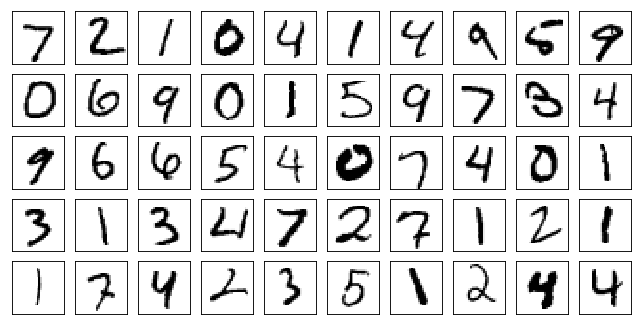

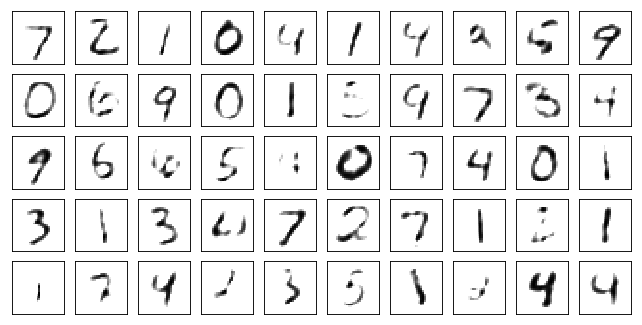

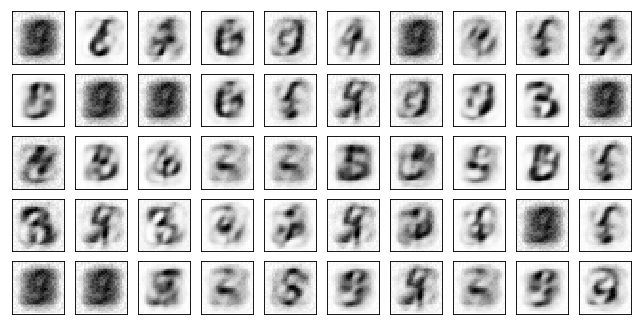

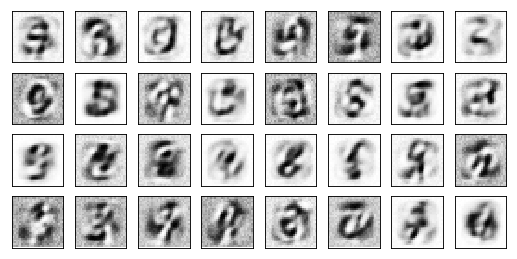

In [22]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot_l1, (5, 10))
plot_mnist(f_to_plot_l1, (5, 10))
plot_mnist(dec_to_plot_l1, (8, 8))